# Introduction
The task here is to compare neural network architectures to each other using their training time and accuracy. The dataset consists of individual drum samples as one might use in a DAW to build a beat. The baseline accuracy is given by a SVM classifier on the MFCC features. Since these features are often displayed as images, and can in fact be processed as images, I suspect a complex CNN will perform best. Another neural network architecture that may work is an LSTM RNN which is most often used for time series problems.

### Outline
- EDA
- Modeling
- Results

In [1]:
import numpy as np
import pandas as pd
import os
import time
import librosa
import matplotlib.pyplot as plt
# supervised learning
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#neural networks
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout,Flatten, Conv2D, MaxPooling2D,LSTM, Input, TimeDistributed
from keras import backend as K

Using TensorFlow backend.


In [2]:
sounds = {"kick":"kick",
          "kik":"kick",
          "snare":"snare",
          "snr":"snare",
          "bongo":"bongo",
          "tom":"tom",
          "hat":"hihat",
          "hh":"hihat",
          "ride":"ride",
          "clap":"clap",
          "cow":"cowbell",
          "bell":"cowbell",
          "conga":"conga"
         }
kits,sound_profiles,files,lengths,mfccs = [],[],[],[],[]
data_path = "data/drums/"
start_time=time.time()
for kit_path in os.listdir(data_path):
    kit = os.listdir(data_path + "/" + kit_path)
    sound_list = [[x,[sounds[sound] for sound in sounds if sound in x.lower()]] for x in kit]
    sound_list = np.array([[x[0],x[1][0]] for x in sound_list if x[1]])
    #print(kit_path,"------------------",sound_list)
    if len(sound_list)>0:
        for sound_path,sound_profile in sound_list:
            # add files, kits, sound_profiles
            files.append(sound_path)
            kits.append(kit_path)
            sound_profiles.append(sound_profile)
            # load data
            data,Fs = librosa.load(data_path + kit_path + "/" + sound_path,sr=None)
            # find longest file: 131811 S
            lengths.append(len(data))
            # zero pad or cut to 2 seconds
            if len(data) > Fs*2: 
                data = data[:Fs*2]
            elif len(data) < Fs*2: 
                data = np.append(data,[0]*(Fs*2-len(data)))
            # process wav
            mfcc_temp = librosa.feature.mfcc(np.array(data),sr=Fs,n_mfcc=40, n_fft=2048, hop_length=512)
            mfcc_slice = mfcc_temp[1:13,:]
            mfccs.append(mfcc_slice.ravel())
print("Processed",len(lengths),"files in {:0.2f}".format(time.time()-start_time),"seconds")

Processed 2642 files in 67.45 seconds


In [3]:
df = pd.DataFrame(mfccs)
X = df.values
df['file']=files
df['kit']=kits
df['sound_profile']=sound_profiles
Y = pd.factorize(sound_profiles)

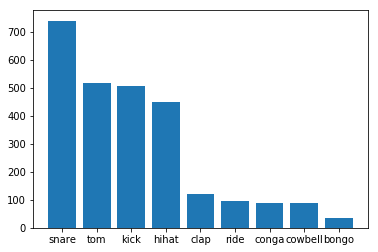

In [4]:
# target distribution
sound_count = df['sound_profile'].value_counts()
plt.bar(range(len(sound_count)),sound_count,tick_label=sound_count.index)
plt.show()

In [5]:
svc = SVC(C=100,kernel='linear')
lg = LogisticRegression(C=1,penalty='l2')
def evaluate(model):
    score = cross_val_score(model,X,Y[0])
    print("SVC Accuracy {:0.4f} +/- {:0.4f} in {:0.2f} seconds".format(score.mean(),score.std(),time.time()-start_time))
evaluate(svc)

SVC Accuracy 0.6998 +/- 0.0241 in 84.97 seconds


# Neural Networks

In [6]:
# prepare neural network variables
num_classes = len(sound_count)
Y_nn = to_categorical(Y[0], num_classes)
# cnn
img_rows, img_cols = mfcc_slice.shape[1], mfcc_slice.shape[0]
X_cnn = X.reshape(X.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
# train test split
X_train, X_test,X_cnn_train,X_cnn_test, Y_train, Y_test = train_test_split(X,X_cnn,Y_nn,test_size=.33)

### 1. Simple MLP

In [7]:
# build simple mlp
mlp = Sequential()
mlp.add(Dense(128,activation='relu',input_dim=X.shape[1]))
mlp.add(Dropout(.33))
mlp.add(Dense(num_classes,activation='softmax'))
mlp.compile(loss="categorical_crossentropy",
            optimizer='adam',
            metrics=['accuracy'])

In [8]:
# evluate simple mlp
mlp_history = mlp.fit(X_train,Y_train,
                      batch_size=128,
                      epochs=10,
                      verbose=1,
                      validation_split=.33)

Train on 1185 samples, validate on 585 samples
Epoch 1/10
1185/1185 [==============================] - 0s 258us/step - loss: 9.2830 - acc: 0.3586 - val_loss: 6.3186 - val_acc: 0.5624
Epoch 2/10
1185/1185 [==============================] - 0s 98us/step - loss: 6.7699 - acc: 0.5342 - val_loss: 5.1804 - val_acc: 0.6188
Epoch 3/10
1185/1185 [==============================] - 0s 101us/step - loss: 5.1805 - acc: 0.6135 - val_loss: 3.8132 - val_acc: 0.6855
Epoch 4/10
1185/1185 [==============================] - 0s 101us/step - loss: 4.2356 - acc: 0.6827 - val_loss: 3.8532 - val_acc: 0.7111
Epoch 5/10
1185/1185 [==============================] - 0s 103us/step - loss: 4.0829 - acc: 0.7148 - val_loss: 3.5378 - val_acc: 0.7316
Epoch 6/10
1185/1185 [==============================] - 0s 97us/step - loss: 3.7148 - acc: 0.7257 - val_loss: 3.3968 - val_acc: 0.7436
Epoch 7/10
1185/1185 [==============================] - 0s 106us/step - loss: 3.4682 - acc: 0.7468 - val_loss: 3.1443 - val_acc: 0.7624
Epo

### 2. Complex MLP

In [9]:
# build complex mlp
cmlp = Sequential()
cmlp.add(Dense(128,activation='relu',input_dim=X.shape[1]))
cmlp.add(Dropout(.5))
cmlp.add(Dense(128,activation='relu'))
cmlp.add(Dropout(.25))
cmlp.add(Dense(64,activation='relu'))
cmlp.add(Dropout(.25))
cmlp.add(Dense(num_classes,activation='softmax'))
cmlp.compile(loss="categorical_crossentropy",
            optimizer='adam',
            metrics=['accuracy'])

In [19]:
cmlp_history = cmlp.fit(X_train,Y_train,
                      batch_size=128,
                      epochs=100,
                      verbose=1,
                      validation_split=.33)

Train on 1185 samples, validate on 585 samples
Epoch 1/100
1185/1185 [==============================] - 0s 120us/step - loss: 1.2065 - acc: 0.7072 - val_loss: 0.9099 - val_acc: 0.7949
Epoch 2/100
1185/1185 [==============================] - 0s 116us/step - loss: 1.0811 - acc: 0.7156 - val_loss: 0.9288 - val_acc: 0.7795
Epoch 3/100
1185/1185 [==============================] - 0s 117us/step - loss: 1.1054 - acc: 0.7063 - val_loss: 0.9231 - val_acc: 0.7880
Epoch 4/100
1185/1185 [==============================] - 0s 107us/step - loss: 1.1043 - acc: 0.7122 - val_loss: 0.9338 - val_acc: 0.7846
Epoch 5/100
1185/1185 [==============================] - 0s 108us/step - loss: 1.1769 - acc: 0.6954 - val_loss: 0.9241 - val_acc: 0.8068
Epoch 6/100
1185/1185 [==============================] - 0s 117us/step - loss: 1.0983 - acc: 0.7072 - val_loss: 0.8405 - val_acc: 0.8034
Epoch 7/100
1185/1185 [==============================] - 0s 116us/step - loss: 1.1229 - acc: 0.7114 - val_loss: 0.8485 - val_acc: 0

1185/1185 [==============================] - 0s 128us/step - loss: 0.6050 - acc: 0.8186 - val_loss: 0.7262 - val_acc: 0.7983
Epoch 61/100
1185/1185 [==============================] - 0s 104us/step - loss: 0.6069 - acc: 0.8068 - val_loss: 0.7436 - val_acc: 0.8051
Epoch 62/100
1185/1185 [==============================] - 0s 106us/step - loss: 0.6323 - acc: 0.8093 - val_loss: 0.7665 - val_acc: 0.8000
Epoch 63/100
1185/1185 [==============================] - 0s 105us/step - loss: 0.5850 - acc: 0.8143 - val_loss: 0.7748 - val_acc: 0.7949
Epoch 64/100
1185/1185 [==============================] - 0s 105us/step - loss: 0.6492 - acc: 0.7966 - val_loss: 0.7609 - val_acc: 0.7983
Epoch 65/100
1185/1185 [==============================] - 0s 100us/step - loss: 0.5855 - acc: 0.8000 - val_loss: 0.7674 - val_acc: 0.8051
Epoch 66/100
1185/1185 [==============================] - 0s 107us/step - loss: 0.6452 - acc: 0.8017 - val_loss: 0.7774 - val_acc: 0.8017
Epoch 67/100
1185/1185 [=======================

### 3. Simple CNN

In [11]:
# build cnn
scnn = Sequential()
scnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
scnn.add(MaxPooling2D(pool_size=(2, 2)))
scnn.add(Dropout(0.5))
scnn.add(Flatten())
scnn.add(Dense(64, activation='relu'))
scnn.add(Dropout(0.5))
scnn.add(Dense(num_classes, activation='softmax'))
scnn.compile(loss="categorical_crossentropy",
             optimizer='adadelta',
             metrics=['accuracy'])

In [12]:
scnn_history = scnn.fit(X_cnn_train,Y_train,
                      batch_size=128,
                      epochs=5,
                      verbose=1,
                      validation_split=.33)

Train on 1185 samples, validate on 585 samples
Epoch 1/5
1185/1185 [==============================] - 2s 2ms/step - loss: 5.7325 - acc: 0.3384 - val_loss: 1.6596 - val_acc: 0.5675
Epoch 2/5
1185/1185 [==============================] - 2s 1ms/step - loss: 2.2212 - acc: 0.3662 - val_loss: 1.4606 - val_acc: 0.5504
Epoch 3/5
1185/1185 [==============================] - 2s 2ms/step - loss: 1.8646 - acc: 0.4641 - val_loss: 1.2116 - val_acc: 0.6308
Epoch 4/5
1185/1185 [==============================] - 2s 2ms/step - loss: 1.7179 - acc: 0.4574 - val_loss: 1.2557 - val_acc: 0.6308
Epoch 5/5
1185/1185 [==============================] - 2s 1ms/step - loss: 1.7130 - acc: 0.4574 - val_loss: 1.2037 - val_acc: 0.6308


### 4. Complex CNN

In [13]:
# build cnn
ccnn = Sequential()
ccnn.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
ccnn.add(Conv2D(16, (3, 3), activation='relu'))
ccnn.add(MaxPooling2D(pool_size=(2, 2)))
ccnn.add(Dropout(0.33))
ccnn.add(Conv2D(16, (3, 3), activation='relu'))
ccnn.add(MaxPooling2D(pool_size=(2, 2)))
ccnn.add(Dropout(0.33))
ccnn.add(Flatten())
ccnn.add(Dense(128, activation='relu'))
ccnn.add(Dropout(0.5))
ccnn.add(Dense(num_classes, activation='softmax'))
ccnn.compile(loss="categorical_crossentropy",
             optimizer='adadelta',
             metrics=['accuracy'])

In [18]:
ccnn_history = ccnn.fit(X_cnn_train,Y_train,
                        batch_size=16,
                        epochs=20,
                        verbose=1,
                        validation_split=.33)

Train on 1185 samples, validate on 585 samples
Epoch 1/20
1185/1185 [==============================] - 3s 2ms/step - loss: 0.9010 - acc: 0.6979 - val_loss: 0.8184 - val_acc: 0.7162
Epoch 2/20
1185/1185 [==============================] - 3s 3ms/step - loss: 0.8631 - acc: 0.6928 - val_loss: 0.7764 - val_acc: 0.7658
Epoch 3/20
1185/1185 [==============================] - 3s 2ms/step - loss: 0.8461 - acc: 0.7046 - val_loss: 0.9819 - val_acc: 0.7316
Epoch 4/20
1185/1185 [==============================] - 3s 3ms/step - loss: 0.7948 - acc: 0.7241 - val_loss: 0.7045 - val_acc: 0.7915
Epoch 5/20
1185/1185 [==============================] - 3s 2ms/step - loss: 0.7973 - acc: 0.7139 - val_loss: 0.7180 - val_acc: 0.7641
Epoch 6/20
1185/1185 [==============================] - 3s 2ms/step - loss: 0.7897 - acc: 0.7443 - val_loss: 0.7480 - val_acc: 0.7556
Epoch 7/20
1185/1185 [==============================] - 3s 3ms/step - loss: 0.7445 - acc: 0.7342 - val_loss: 0.6947 - val_acc: 0.7607
Epoch 8/20
1185

### 5. LSTM RNN

In [15]:
row_hidden = 32
col_hidden = 32
row, col, pixel = X_cnn.shape[1:]
x = Input(shape=(row, col, pixel))

encoded_rows = TimeDistributed(LSTM(row_hidden))(x)
encoded_columns = LSTM(col_hidden)(encoded_rows)

prediction = Dense(num_classes, activation='softmax')(encoded_columns)
rnn = Model(x, prediction)
rnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
rnn_history = rnn.fit(X_cnn_train,Y_train,
                      batch_size=8,
                      epochs=5,
                      verbose=1,
                      validation_split=.33)

Train on 1185 samples, validate on 585 samples
Epoch 1/5
1185/1185 [==============================] - 19s 16ms/step - loss: 1.8404 - acc: 0.3283 - val_loss: 1.6459 - val_acc: 0.4359
Epoch 2/5
1185/1185 [==============================] - 18s 15ms/step - loss: 1.6635 - acc: 0.3992 - val_loss: 1.5924 - val_acc: 0.4359
Epoch 3/5
1185/1185 [==============================] - 18s 15ms/step - loss: 1.6026 - acc: 0.4118 - val_loss: 1.5011 - val_acc: 0.4650
Epoch 4/5
1185/1185 [==============================] - 18s 15ms/step - loss: 1.5025 - acc: 0.4329 - val_loss: 1.4457 - val_acc: 0.4752
Epoch 5/5
1185/1185 [==============================] - 19s 16ms/step - loss: 1.5033 - acc: 0.4262 - val_loss: 1.4773 - val_acc: 0.4667


# Results

In [20]:
scores = {"Simple MLP":0.0,
          "Complex MLP":0.0,
          "Simple CNN":0.0,
          "Complex CNN":0.0,
          "LSTM RNN":0.0
         }
_,scores["Simple MLP"] = mlp.evaluate(X_test,Y_test,verbose=0)
_,scores["Complex MLP"] = cmlp.evaluate(X_test,Y_test,verbose=0)
_,scores["Simple CNN"] = scnn.evaluate(X_cnn_test,Y_test,verbose=0)
_,scores["Complex CNN"] = ccnn.evaluate(X_cnn_test,Y_test,verbose=0)
_,scores["LSTM RNN"] = rnn.evaluate(X_cnn_test,Y_test,verbose=0)
display(scores)

{'Simple MLP': 0.75,
 'Complex MLP': 0.7809633027522935,
 'Simple CNN': 0.6055045871559633,
 'Complex CNN': 0.7706422018348624,
 'LSTM RNN': 0.463302752293578}

Judging by the holdout group, the Complex MLP performed the best achieving an accuracy of 78.09%. The other complex model came in second, scoring within 1%. My assumption that the CNNs would perform best did not hold true here. A simple SVM classifier was able to perform similarly well. Interestingly, the RNN did not perform well. These models are known for performing well with sequential data, and although music is sequential, we did not feed the model sequential features. If I were to deploy a model I may consider the best performer as training time did not vary considerably between these methods. For production, I would choose the Complex MLP for its high score and moderate runtime.  
<br>Further research may include gathering more data and generating different features. While there was a sizeable amount of data present, neural networks are known to perform better on large datasets. The MFCC features are widely regarded as vital features in audio recognition, however, that does not exclude the efficiency of other audio features. 